In [6]:
import sys
import os
os.chdir("/athena/marchionnilab/scratch/lab_data/Mohamed/pca_TME")
#sys.setrecursionlimit(22000)
from pathlib import Path
import scanpy as sc
from matplotlib.pyplot import ion
from scutils.figures.base import basics
from scutils.figures.prostate import annotate_cell_types_prostate
from scutils.qc import PreprocessRNA
from mousipy import translate
import pandas as pd
import scipy.sparse as sp
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
sc.settings.figdir = ''

In [7]:
sc._settings.ScanpyConfig(plot_suffix = '', n_jobs = 20, max_memory = 100)
sc.set_figure_params(dpi_save = 300)

In [8]:
adata_mouse = sc.read_h5ad('outs/h5ads/fapcm_fibroblasts_v6_clean_regulons_5.h5ad', chunk_size=100000)
adata_mouse.obs['cluster'] = adata_mouse.obs['cluster'].astype('str')
adata_mouse.obs['cluster'].value_counts()

1      2541
0      1442
5       997
3       903
6       895
7       753
4       733
nan     406
2       310
Name: cluster, dtype: int64

In [9]:
# filter the na
adata_mouse = adata_mouse[adata_mouse.obs['cluster'] != 'nan', :]
adata_mouse.obs['cluster'].value_counts()

1    2541
0    1442
5     997
3     903
6     895
7     753
4     733
2     310
Name: cluster, dtype: int64

In [10]:
# save the normalized data (not z-scored) for cellchat
adata_mouse_raw = adata_mouse.copy()
adata_mouse_raw = adata_mouse_raw.raw.to_adata()
adata_mouse_raw.X = sp.csr_matrix.todense(adata_mouse_raw.X)
adata_mouse_raw.X = adata_mouse_raw.to_df()
adata_mouse_raw.write('outs/forCellChat/adata_mouse_norm.h5ad')

# Process the human data using ingest

In [11]:
# load the human data
adata_human = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons.h5ad', chunk_size=100000)

In [12]:
# change the var_names to match mouse gene symbols
adata_human.var_names = [gene.title() for gene in adata_human.var_names]

# subset also the adata_human.raw
tempAdata = adata_human.raw.to_adata()
tempAdata.var_names = [gene.title() for gene in tempAdata.var_names]
adata_human.raw = tempAdata

In [13]:
adata_human.var_names
adata_human.raw.var_names

Index(['A1Bg', 'A1Bg-As1', 'A1Cf', 'A2M', 'A2M-As1', 'A2Ml1', 'A2Ml1-As1',
       'A2Ml1-As2', 'A3Galt2', 'A4Galt',
       ...
       'Zw10', 'Zwilch', 'Zwint', 'Zxda', 'Zxdb', 'Zxdc', 'Zyg11A', 'Zyg11B',
       'Zyx', 'Zzef1'],
      dtype='object', length=30631)

In [14]:
# find common genes
var_names = adata_mouse.var_names.intersection(adata_human.var_names)
len(var_names)

1342

In [15]:
# subset
adata_mouse = adata_mouse[:, var_names]
adata_human = adata_human[:, var_names]


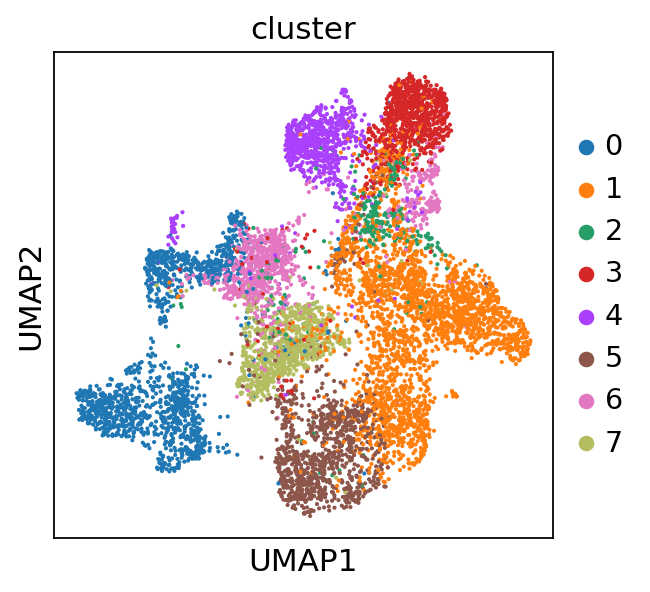

In [16]:
# recompute the neighbors for the adata_mouse (ref dataset)
sc.pp.pca(adata_mouse)
sc.pp.neighbors(adata_mouse)
sc.tl.umap(adata_mouse)
sc.pl.umap(adata_mouse, color='cluster', save = 'mouse_umap.png')

In [21]:
# divide the human data into ERG pos and neg
adata_human_ERGpos = adata_human[adata_human.obs.erg=='positive']
adata_human_ERGneg = adata_human[adata_human.obs.erg=='negative']

In [24]:
# mapping the clusters from mouse to human using ingest
sc.tl.ingest(adata_human, adata_mouse, obs='cluster')

In [27]:
# divide the human data into ERG pos and neg
adata_human_ERGpos = adata_human[adata_human.obs.erg=='positive']
adata_human_ERGneg = adata_human[adata_human.obs.erg=='negative']

In [25]:
# the same with ERG pos and neg
sc.tl.ingest(adata_human_ERGpos, adata_mouse, obs='cluster')
sc.tl.ingest(adata_human_ERGneg, adata_mouse, obs='cluster')

In [28]:
# Number of cells in each cluster: mouse vs human 
print(adata_mouse.obs['cluster'].value_counts())
print(adata_human.obs['cluster'].value_counts())
print(adata_human_ERGpos.obs['cluster'].value_counts())
print(adata_human_ERGneg.obs['cluster'].value_counts())

1    2541
0    1442
5     997
3     903
6     895
7     753
4     733
2     310
Name: cluster, dtype: int64
6    4052
1    2569
0    1059
7     518
4     151
3     150
2      67
5      62
Name: cluster, dtype: int64
6    3438
1    1935
0     853
7     438
3     133
4      91
5      53
2      49
Name: cluster, dtype: int64
1    634
6    614
0    206
7     80
4     60
2     18
3     17
5      9
Name: cluster, dtype: int64


In [13]:
adata_human.uns['cluster_colors'] = adata_mouse.uns['cluster_colors']  # fix colors

# save the human count matrix with the cluster info

In [33]:
adata_human.write('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot.h5ad')

In [28]:
adata_human.write_loom('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot.loom', write_obsm_varm = True)

# load the annot human data

In [3]:
adata_human = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot.h5ad', chunk_size=100000)

############

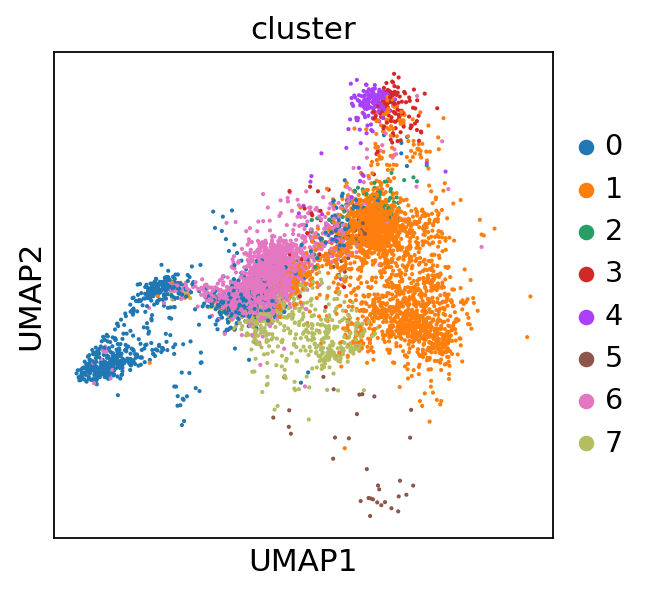

In [16]:
sc.pl.umap(adata_human, color='cluster', save = 'human_umap.png')

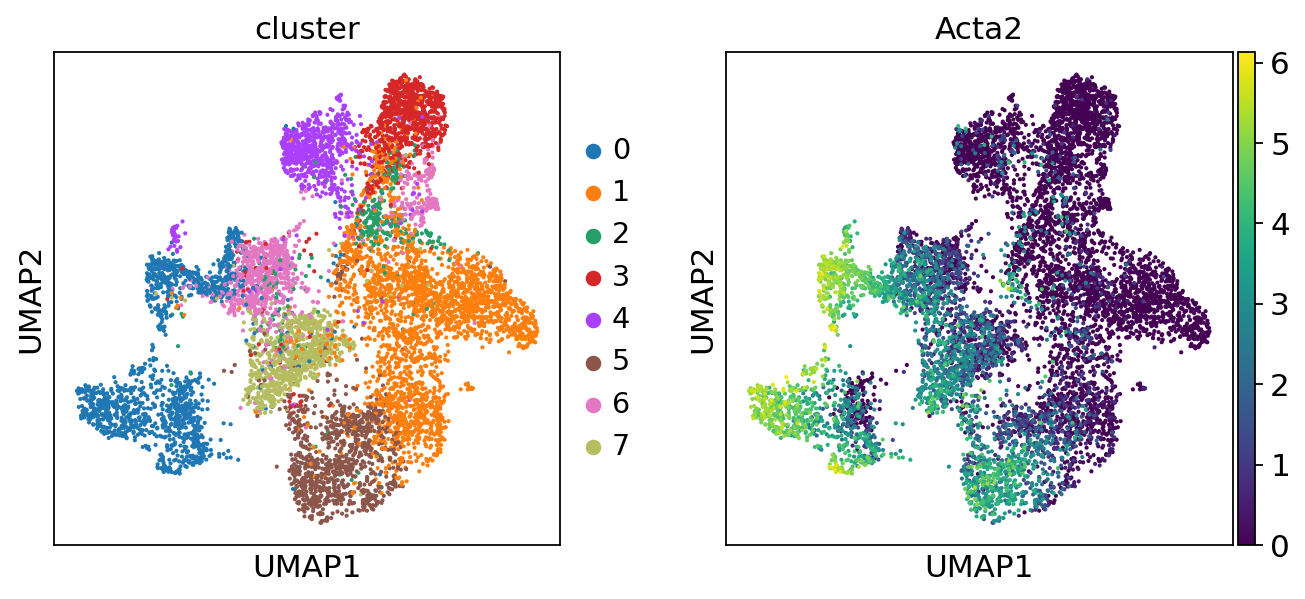

In [17]:
sc.pl.umap(adata_mouse, color=['cluster', 'Acta2'], save = 'mouse_ACTA2.png')

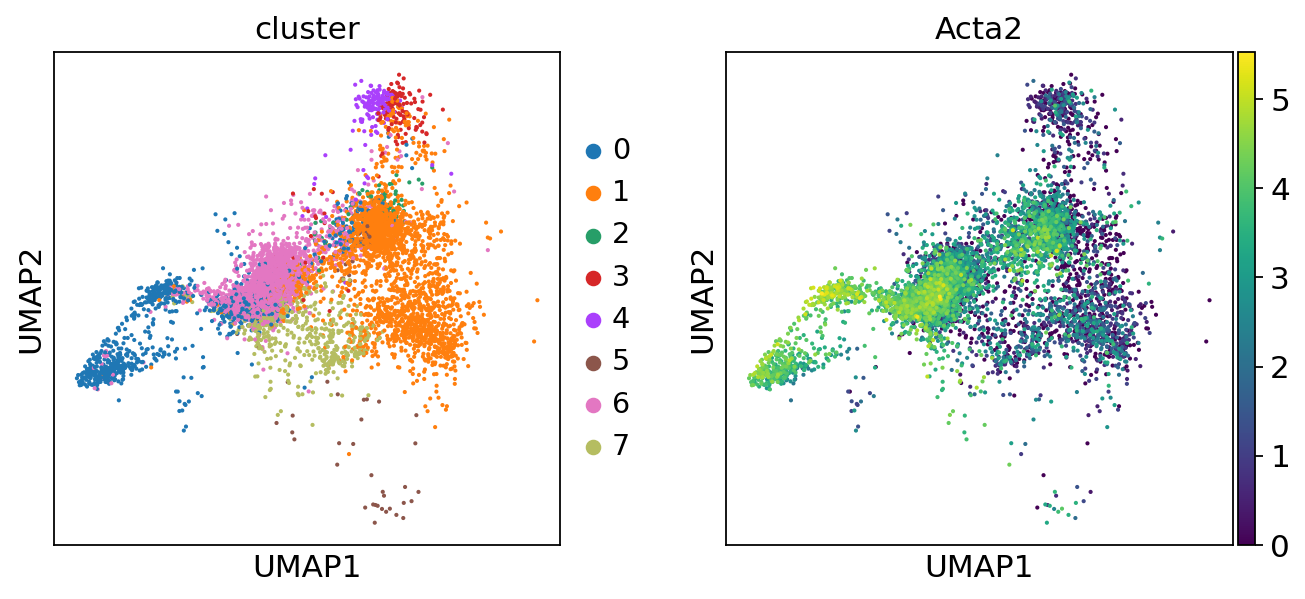

In [18]:
sc.pl.umap(adata_human, color=['cluster', 'Acta2'], save = 'human_ACTA2.png')

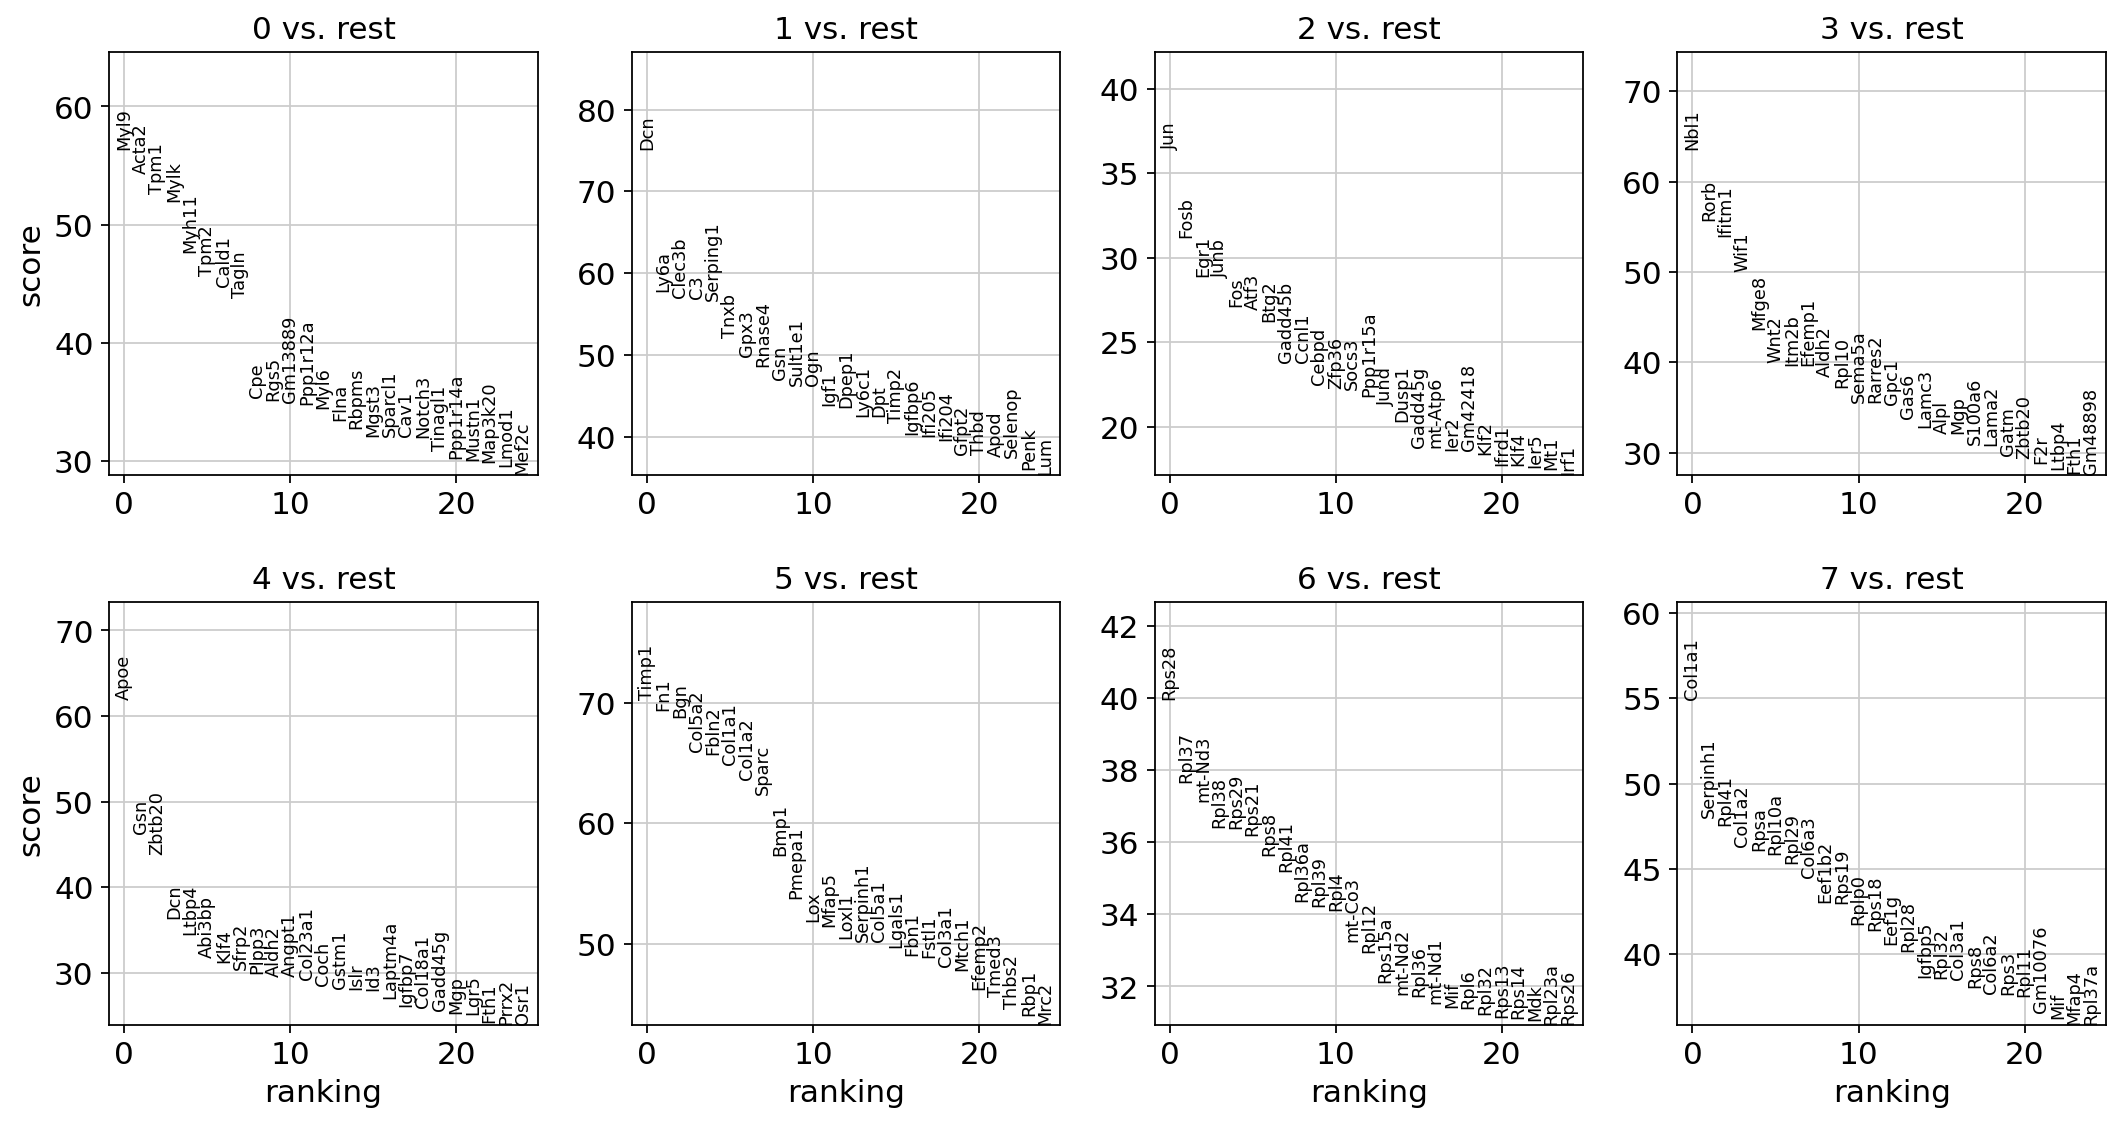

In [19]:
sc.tl.rank_genes_groups(adata_mouse, 'cluster', method='t-test')
sc.pl.rank_genes_groups(adata_mouse, n_genes=25, sharey=False, save = 'mouseMarkers.png')

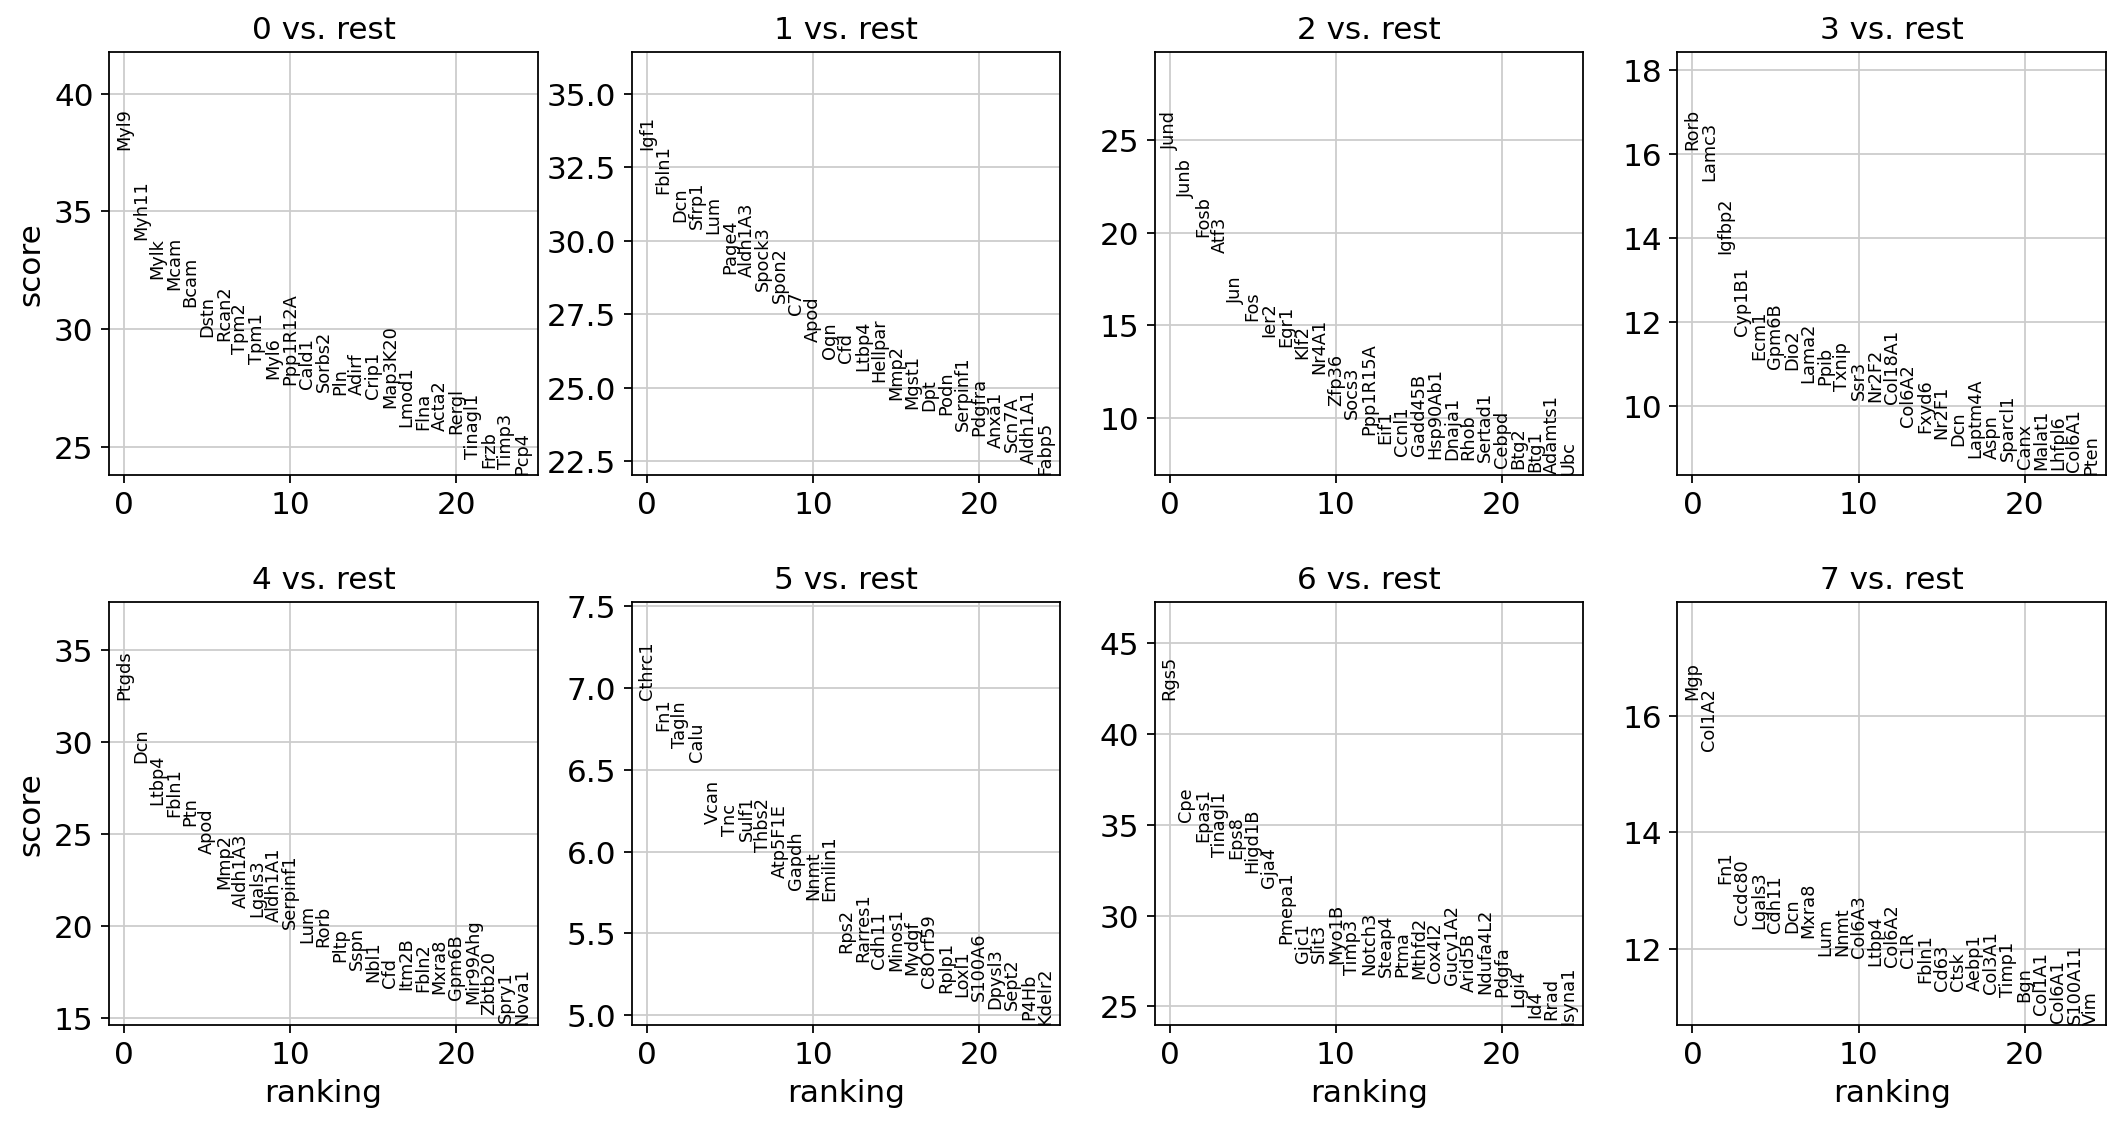

In [20]:
sc.tl.rank_genes_groups(adata_human, 'cluster', method='t-test')
sc.pl.rank_genes_groups(adata_human, n_genes=25, sharey=False, save = 'humanMarkers.png')

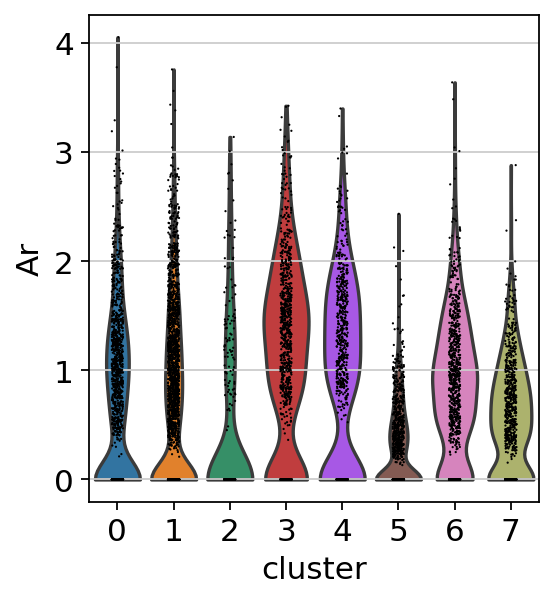

In [21]:
sc.pl.violin(adata_mouse, ['Ar'], groupby = 'cluster', save = 'AR_mouse.png')

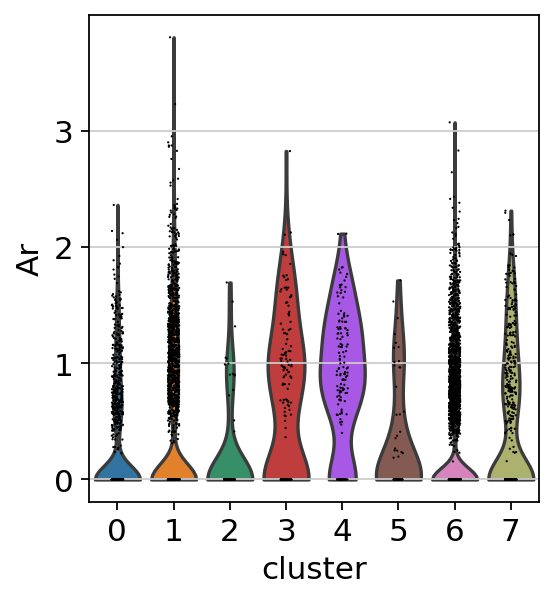

In [22]:
sc.pl.violin(adata_human, ['Ar'], groupby = 'cluster', save = 'AR_human.png')

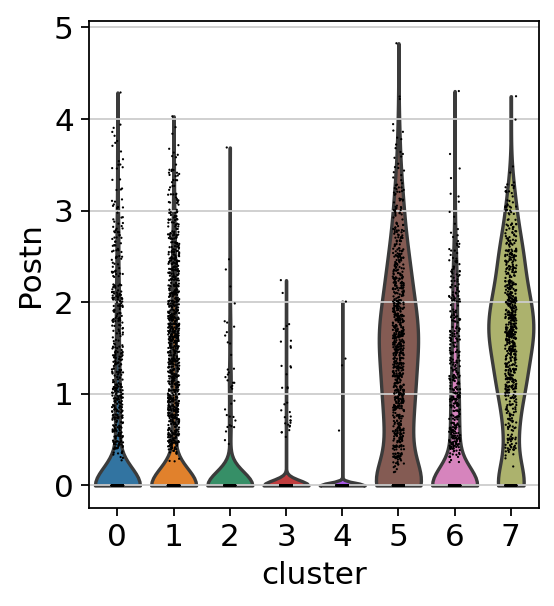

In [26]:
sc.pl.violin(adata_mouse, ['Postn'], groupby = 'cluster', save = 'Postn_mouse.png')

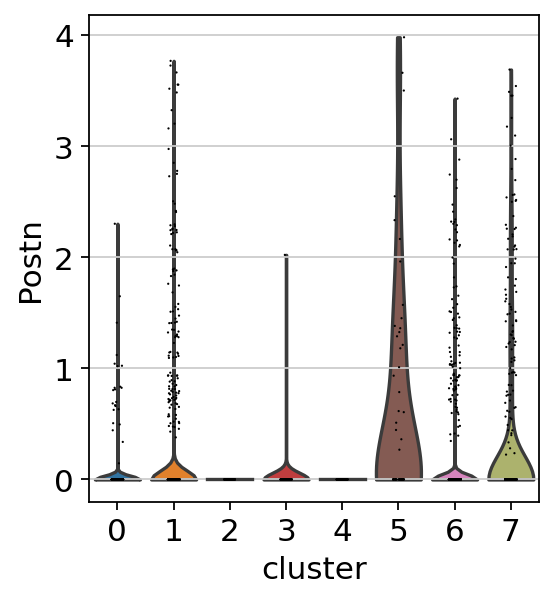

In [27]:
sc.pl.violin(adata_human, ['Postn'], groupby = 'cluster', save = 'Postn_human.png')

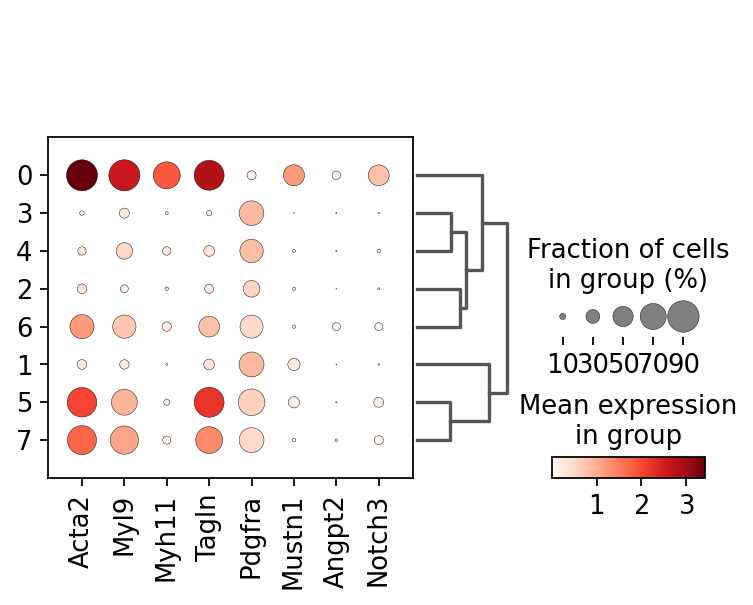

In [143]:
sc.pl.rank_genes_groups_dotplot(adata_mouse, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3'], save = 'c0_mouse.png')

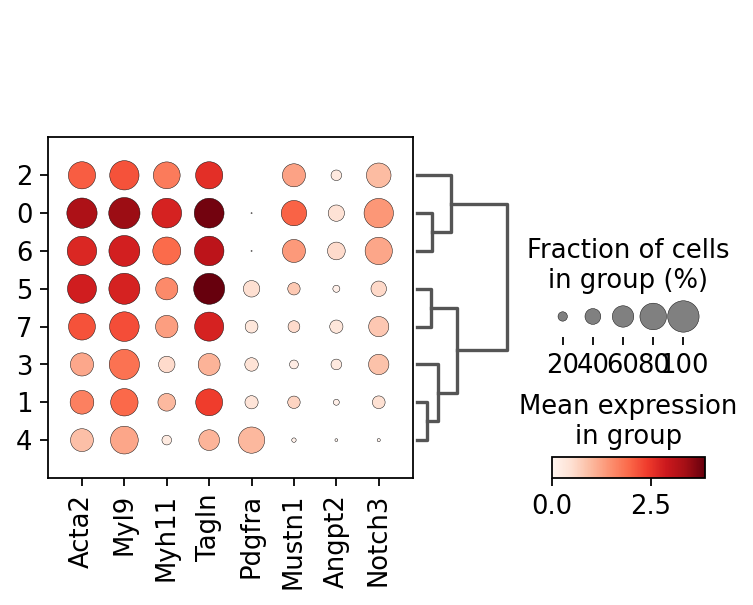

In [144]:
sc.pl.rank_genes_groups_dotplot(adata_human, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3'], save = 'c0_human.png')

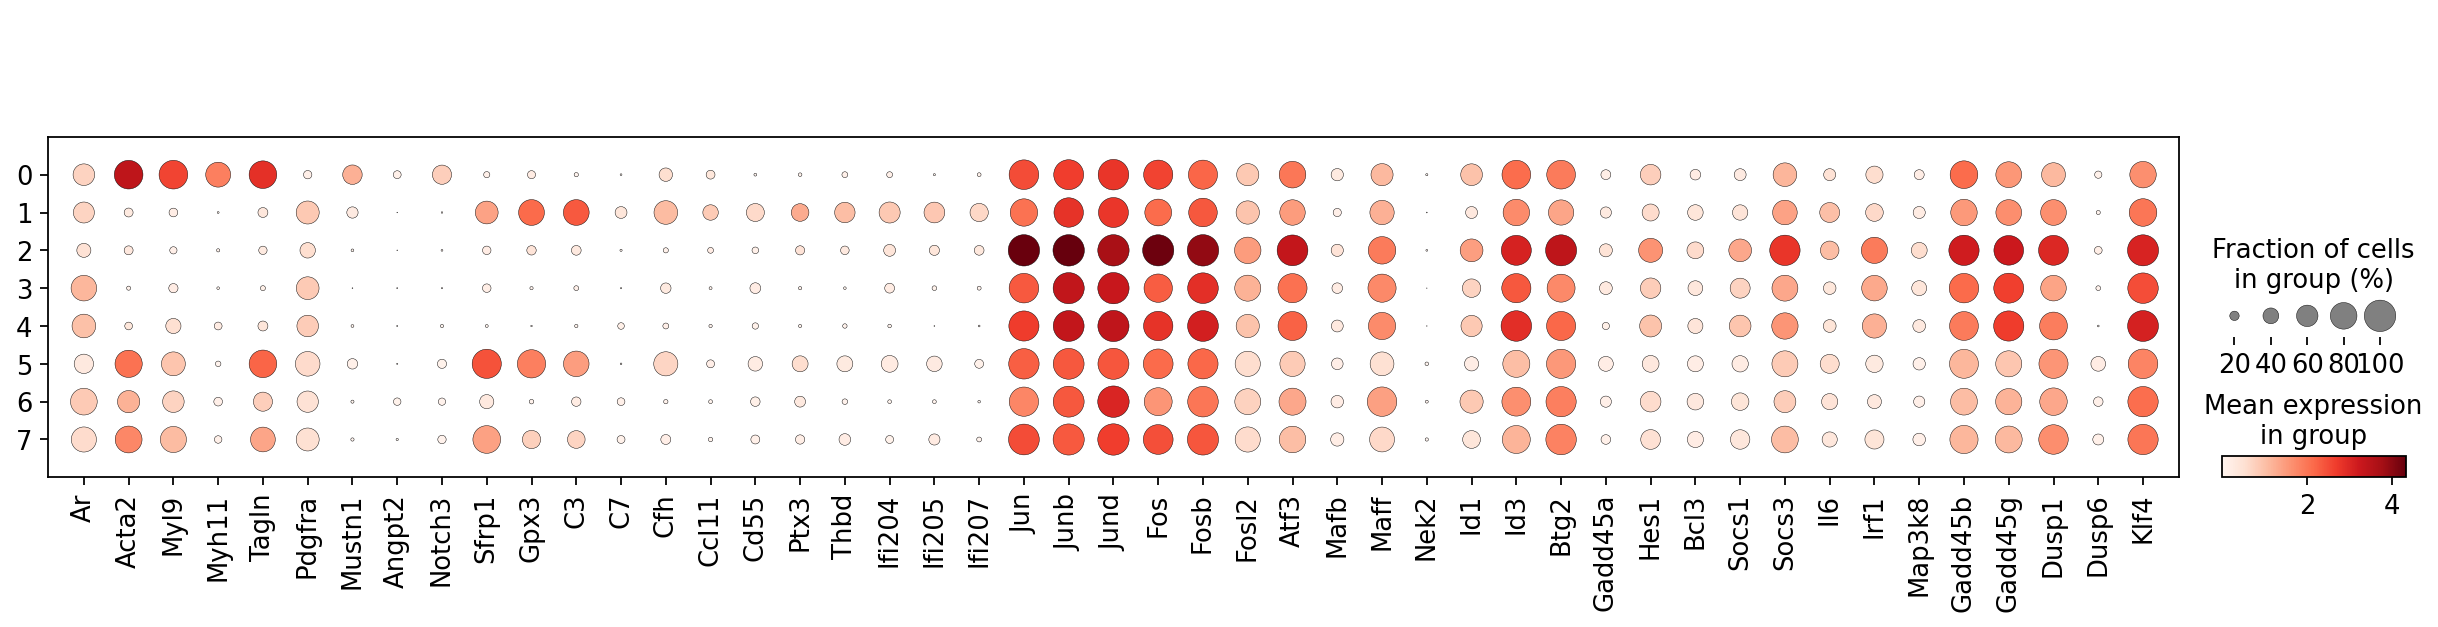

In [156]:
sc.pl.rank_genes_groups_dotplot(adata_mouse, var_names = ['Ar', 'Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3', 'Sfrp1', 'Gpx3', 'C3', 'C7', 'Cfh', 'Ccl11', 'Cd55', 'Ptx3', 'Thbd', 'Ifi204', 'Ifi205', 'Ifi207', 'Jun', 'Junb', 'Jund', 'Fos', 'Fosb', 'Fosl2', 'Atf3', 'Mafb', 'Maff', 'Nek2', 'Id1', 'Id3', 'Btg2', 'Gadd45a', 'Hes1', 'Bcl3', 'Socs1', 'Socs3', 'Il6', 'Irf1', 'Map3k8', 'Gadd45b', 'Gadd45g', 'Dusp1', 'Dusp6', 'Klf4'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'mouse.png')


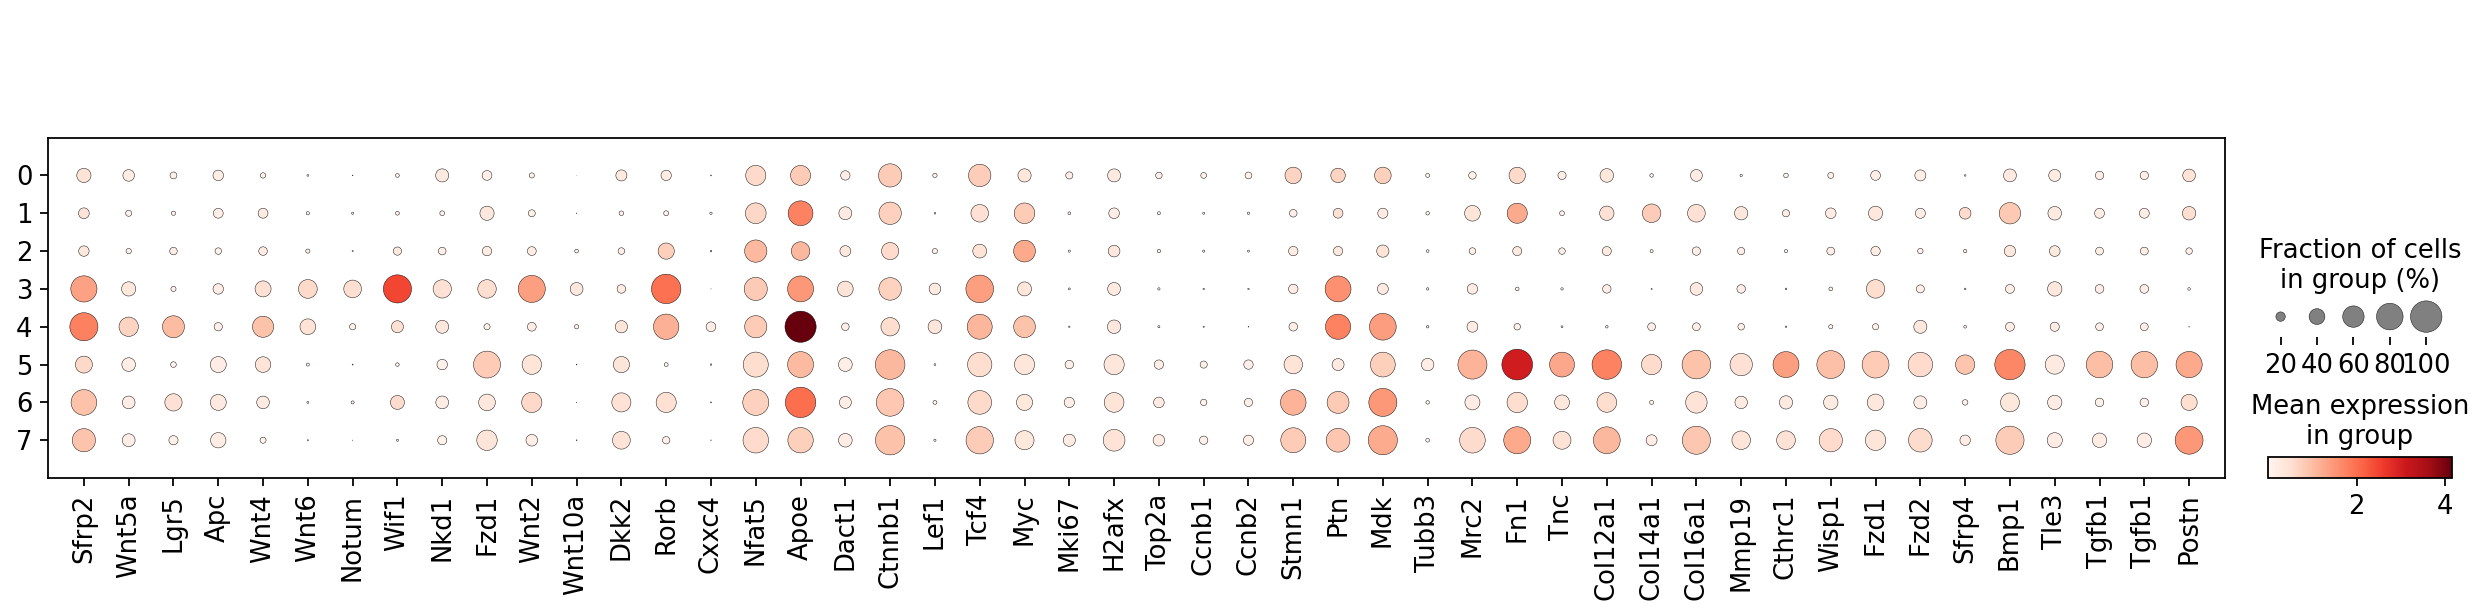

In [173]:
sc.pl.rank_genes_groups_dotplot(adata_mouse, var_names = ['Sfrp2', 'Wnt5a', 'Lgr5', 'Apc', 'Wnt4', 'Wnt6', 'Notum', 'Wif1', 'Nkd1', 'Fzd1', 'Wnt2', 'Wnt10a', 'Dkk2', 'Rorb', 'Cxxc4', 'Nfat5', 'Apoe', 'Dact1', 'Ctnnb1', 'Lef1', 'Tcf4', 'Myc', 'Mki67', 'H2afx', 'Top2a', 'Ccnb1', 'Ccnb2', 'Stmn1', 'Ptn', 'Mdk', 'Tubb3', 'Mrc2', 'Fn1', 'Tnc', 'Col12a1', 'Col14a1', 'Col16a1', 'Mmp19', 'Cthrc1', 'Wisp1', 'Fzd1', 'Fzd2', 'Sfrp4', 'Bmp1', 'Tle3', 'Tgfb1', 'Tgfb1', 'Postn'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'mouse2.png')


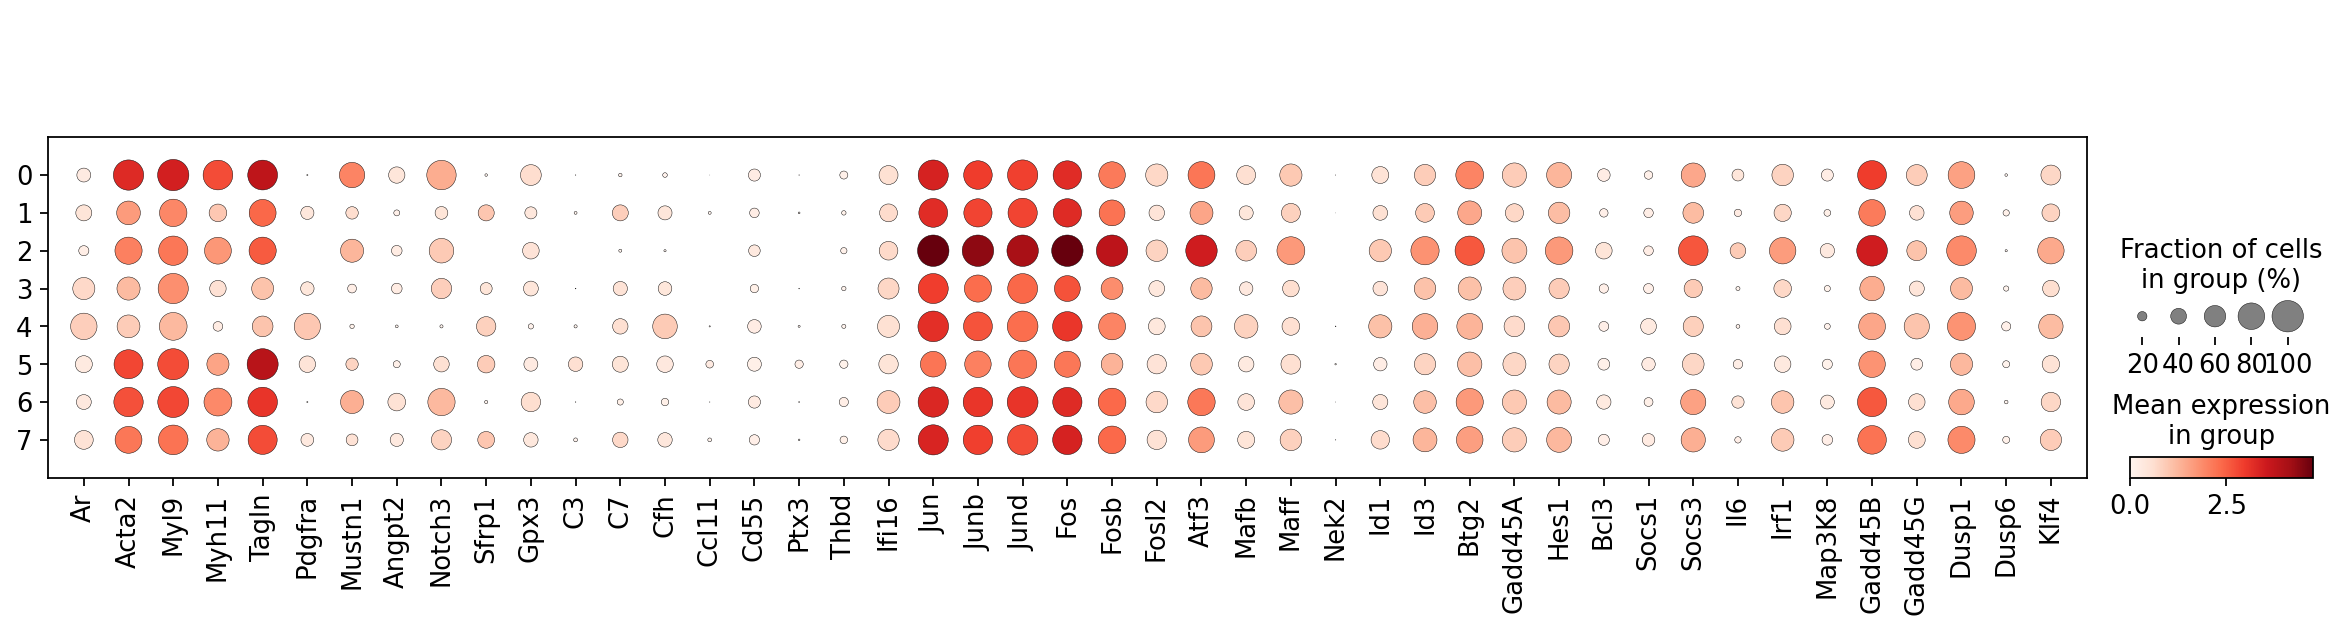

In [171]:
sc.pl.rank_genes_groups_dotplot(adata_human, var_names = ['Ar', 'Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3', 'Sfrp1', 'Gpx3', 'C3', 'C7', 'Cfh', 'Ccl11', 'Cd55', 'Ptx3', 'Thbd', 'Ifi16', 'Jun', 'Junb', 'Jund', 'Fos', 'Fosb', 'Fosl2', 'Atf3', 'Mafb', 'Maff', 'Nek2', 'Id1', 'Id3', 'Btg2', 'Gadd45A', 'Hes1', 'Bcl3', 'Socs1', 'Socs3', 'Il6', 'Irf1', 'Map3K8', 'Gadd45B', 'Gadd45G', 'Dusp1', 'Dusp6', 'Klf4'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'human.png')


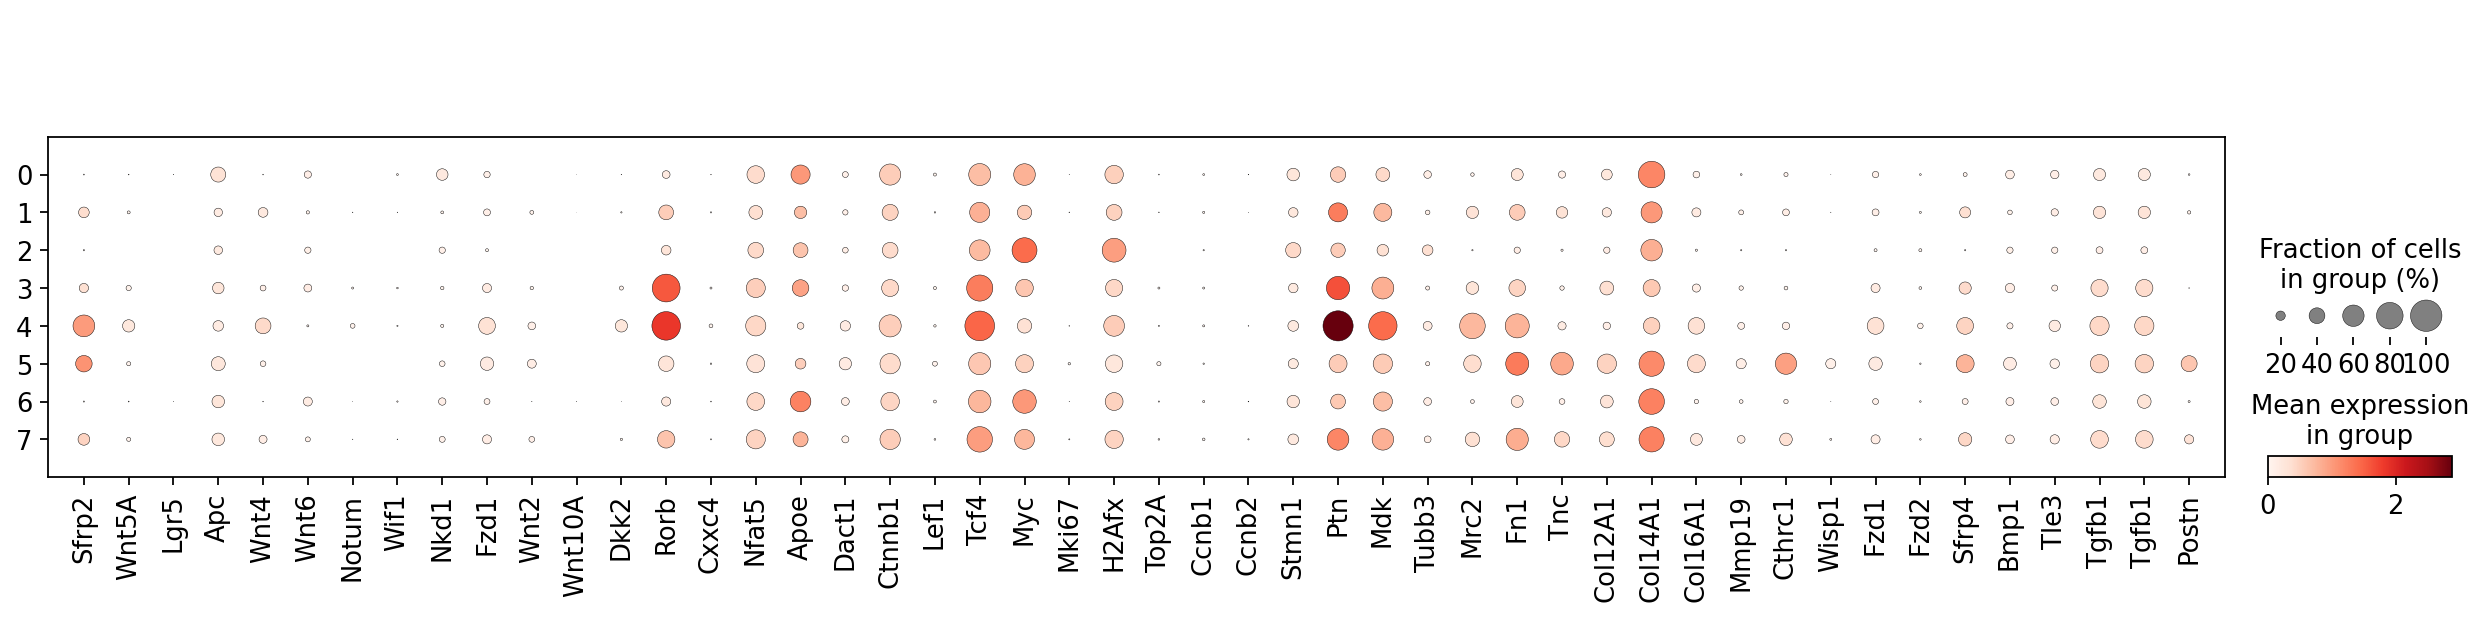

In [178]:
sc.pl.rank_genes_groups_dotplot(adata_human, var_names = ['Sfrp2', 'Wnt5A', 'Lgr5', 'Apc', 'Wnt4', 'Wnt6', 'Notum', 'Wif1', 'Nkd1', 'Fzd1', 'Wnt2', 'Wnt10A', 'Dkk2', 'Rorb', 'Cxxc4', 'Nfat5', 'Apoe', 'Dact1', 'Ctnnb1', 'Lef1', 'Tcf4', 'Myc', 'Mki67', 'H2Afx', 'Top2A', 'Ccnb1', 'Ccnb2', 'Stmn1', 'Ptn', 'Mdk', 'Tubb3', 'Mrc2', 'Fn1', 'Tnc', 'Col12A1', 'Col14A1', 'Col16A1', 'Mmp19', 'Cthrc1', 'Wisp1', 'Fzd1', 'Fzd2', 'Sfrp4', 'Bmp1', 'Tle3', 'Tgfb1', 'Tgfb1', 'Postn'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'human2.png')


In [112]:
adata_mouse

AnnData object with n_obs × n_vars = 8574 × 1342
    obs: 'batch', 'key', 'model', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'scrubletscores', 'scrubletdoublets', 'leiden', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'endothelial', 'fibroblast', 'myofibroblast', 'dendritic', 'cCDs', 'langherhans_like', 'b', 't_nk', 'myeloid', 'mast', 'luminal', 'basal', 'notluminal', 'macrophages', 'neuroendocrine', 'seminal_vesicle_basal', 'seminal_vesicle_luminal', 'seminal_vesicle_ionocyte', 'Regulon(Arid5a)', 'Regulon(Arid5b)', 'Regulon(Ascl1)', 'Regulon(Ascl2)', 'Regulon(Atf3)', 'Regulon(Bach1)', 'Regulon(Batf)', 'Regulon(Bcl3)', 'Regulon(Cebpa)', 'Regulon(Cebpb)', 'Regulon(Cebpd)', 'Regulon(Creb5)', 'Regulon(Crem)', 'Regulon(Dusp26)', 'Regulon(Egr1)', 'Regulon(Egr2)', 'Regulon(Egr3)', 'Regulon(Egr4)', 'Regulon(Eomes)', 'Regulon(Erg)', 'Regulon(Ets1)', '

In [163]:
adata_human.raw.var_names

Index(['A1Bg', 'A1Bg-As1', 'A1Cf', 'A2M', 'A2M-As1', 'A2Ml1', 'A2Ml1-As1',
       'A2Ml1-As2', 'A3Galt2', 'A4Galt',
       ...
       'Zw10', 'Zwilch', 'Zwint', 'Zxda', 'Zxdb', 'Zxdc', 'Zyg11A', 'Zyg11B',
       'Zyx', 'Zzef1'],
      dtype='object', length=30631)

# save the normalized human data (not z-scored) for cellchat

In [114]:
adata_human_raw = adata_human.raw.to_adata()
adata_human_raw.X = sp.csr_matrix.todense(adata_human_raw.X)
adata_human_raw.X = adata_human_raw.to_df()
adata_human_raw.write('outs/forCellChat/adata_human_norm.h5ad')

In [60]:
adata_human_raw

AnnData object with n_obs × n_vars = 8628 × 30631
    obs: 'key', 'condition', 'tn', 'case', 'erg', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'scrubletscores', 'scrubletdoublets', 'leiden', '_scvi_batch', '_scvi_labels', 'endothelial', 'fibroblast', 'myofibroblast', 'dendritic', 'pDC', 'cCDs', 'langherhans_like', 'b', 't_nk', 'myeloid', 'mast', 'luminal', 'basal', 'notbasal', 'macrophages', 'neuroendocrine', 'seminal_vesicle_basal', 'seminal_vesicle_luminal', 'seminal_vesicle_ionocyte', 'Regulon(ARID5B)', 'Regulon(ATF3)', 'Regulon(BCL11A)', 'Regulon(BHLHE22)', 'Regulon(CDX1)', 'Regulon(CEBPB)', 'Regulon(CEBPD)', 'Regulon(CREB5)', 'Regulon(CREM)', 'Regulon(DDIT3)', 'Regulon(E2F2)', 'Regulon(E2F8)', 'Regulon(EBF1)', 'Regulon(EGR1)', 'Regulon(EGR3)', 'Regulon(EOMES)', 'Regulon(ERG)', 'Regulon(FOS)', 'Regulon(FOSB)', 'Regulon(FOSL1)', 'Regulon(FOXA1)', 'Regulon(FOXP3)', 'Regulon(FOXQ1)', 'Regulon(GATA2)', 'Regulon(GLIS2)', 'Regulon(HOXB13)', 'Regulon(IRF4)', '

In [65]:
adata_human_raw.obs['key'].value_counts()

s2035422_near_normal        1034
s2118793_seminal_vesicle    1007
s2035422_normal              958
s2118793_tumor               659
s2015748_normal              486
s2034770_normal              468
s2034770_tumor               461
s2140737_tumor               435
s2118793_far_normal          390
s2140737_near_normal         316
s2140737_central             286
s2118793_central_zone        282
s2133746_tumor               257
s2138509_tumor1              199
s2138509_tumor2              195
s2138509_normal              179
s2015748_tumor               154
s2027761_normal              149
s2140737_far_normal          146
s2133746_near_normal         138
s2133746_central             110
s2118793_near_normal          98
s2142902_central              78
s2142902_tumor                55
s2142902_far_normal           32
s2133746_far_normal           26
s2027761_tumor                17
s2142902_normal               13
Name: key, dtype: int64

###############

# Regulons

In [4]:
adata_human = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot.h5ad', chunk_size=100000)

In [5]:
# load the scenic output
auc_mtx = pd.read_csv('human/scenic/results/human_fibroblasts.auc.csv', index_col=0)
bin_mtx = pd.read_csv('human/scenic/results/human_fibroblasts.bin.csv', index_col=0)
thresholds = pd.read_csv('human/scenic/results/human_fibroblasts.thresholds.csv', index_col=0).threshold

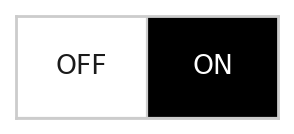

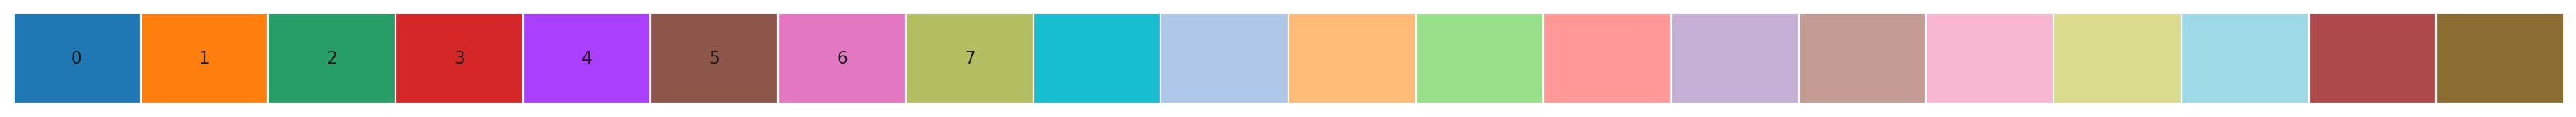

In [6]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

def savesvg(fname: str, fig, folder: str) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format="svg")

N_COLORS = len(adata_human.obs.cluster.dtype.categories)
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

cell_type_color_lut = dict(zip(adata_human.obs.cluster.dtype.categories, COLORS))
cell_type_color_lut = dict(zip(adata_human.obs.cluster.dtype.categories, adata_human.uns['cluster_colors']))
#cell_id2cell_type_lut = anndata.var.set_index('cell_id').cell_type.to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('human/scenic/figures/onoff.svg', fig, '')

sns.set()
sns.set(font_scale=0.8)
fig = palplot(sns.color_palette(COLORS), adata_human.obs.cluster.dtype.categories, size=1.0)
savesvg('human/scenic/figures/cluster_colors.svg', fig, '')

In [14]:
# Select the top 5 regulons from each cell type
cats = sorted(list(set(adata_human.obs['cluster'])))
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))


NameError: name 'rss_cellType' is not defined

In [ ]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Celltype_Garnett'] ]

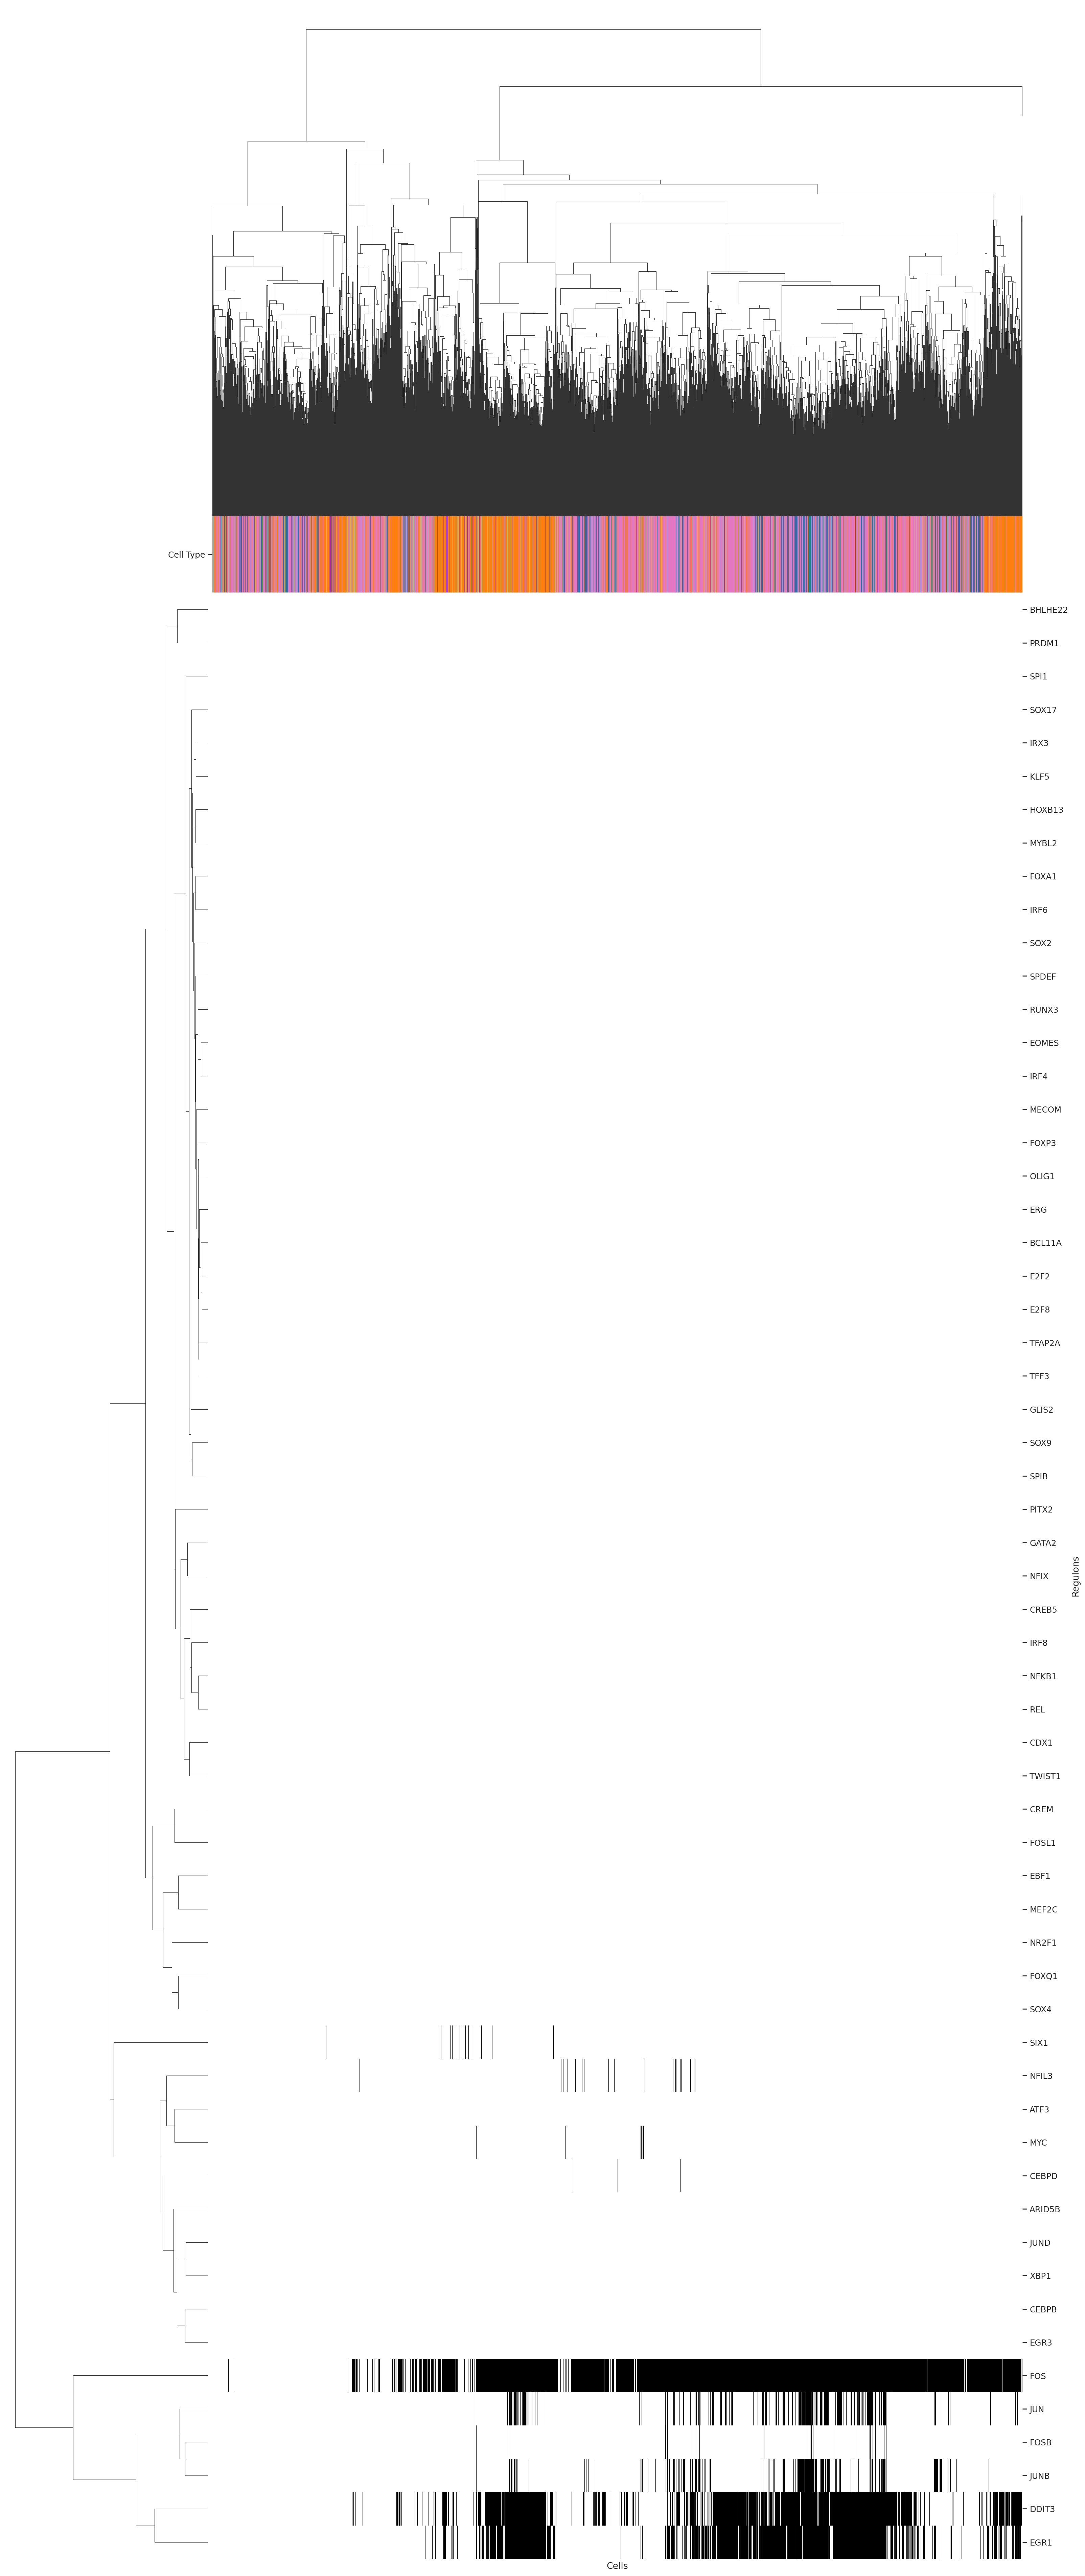

In [10]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(auc_mtx.T,
                col_colors=auc_mtx.index.map(adata_human.obs['cluster'].to_dict()).map(cell_type_color_lut),
                yticklabels=True,
                cmap=bw_palette, figsize=(20,50))
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
g.fig.savefig(os.path.join('human/scenic/figures', 'clustermap.png'), dpi=200, format='png')

bin_mtx_clustered = auc_mtx.T.copy()
# bin_mtx_clustered.rename(columns=df_annotations.set_index('cell_id')['cell_type'].to_dict(), inplace=True)
bin_mtx_clustered.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind].to_excel(os.path.join('human/scenic/results', 'bindata.xlsx'))
g.fig.savefig(os.path.join('human/scenic/figures', 'clustermap_binary.png'), dpi=200, format='png')
